In [28]:
import torch
import pandas as pd
from torchvision import transforms
from PIL import Image
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from itertools import chain

In [29]:
# Load cosmetics data
pd.set_option('display.max_colwidth', None)
cosmetics_df = pd.read_csv("/kaggle/input/cosmetics/cosmetics.csv")

In [30]:
# Check for null values in each column
print("Null values in each column:")
print(cosmetics_df.isnull().sum())

Null values in each column:
Label          0
Brand          0
Name           0
Price          0
Rank           0
Ingredients    0
Combination    0
Dry            0
Normal         0
Oily           0
Sensitive      0
dtype: int64


In [31]:
def price_category(price):
    if price < 50:
        return 'Low'
    elif 50 <= price < 150:
        return 'Mid-range'
    else:
        return 'High'

In [32]:
cosmetics_df['Price_category'] = cosmetics_df['Price'].apply(price_category)

In [33]:
# Check for duplicates 
print(f"Duplicate entries: {cosmetics_df.duplicated(subset=['Name', 'Ingredients']).sum()}")
cosmetics_df.drop_duplicates(subset=['Name', 'Ingredients'], inplace=True)

Duplicate entries: 0


In [34]:
print(cosmetics_df.head())

         Label           Brand                                           Name  \
0  Moisturizer          LA MER                                Crème de la Mer   
1  Moisturizer           SK-II                       Facial Treatment Essence   
2  Moisturizer  DRUNK ELEPHANT                     Protini™ Polypeptide Cream   
3  Moisturizer          LA MER                    The Moisturizing Soft Cream   
4  Moisturizer    IT COSMETICS  Your Skin But Better™ CC+™ Cream with SPF 50+   

   Price  Rank  \
0    175   4.1   
1    179   4.1   
2     68   4.4   
3    175   3.8   
4     38   4.1   

                                                                                                                                                                                                                                                                                                                                                                                                                    

In [35]:
min_price = cosmetics_df['Price'].min()
max_price = cosmetics_df['Price'].max()
print(f"\n Price range of products: ₹{int(min_price)} to ₹{int(max_price)}")


 Price range of products: ₹3 to ₹370


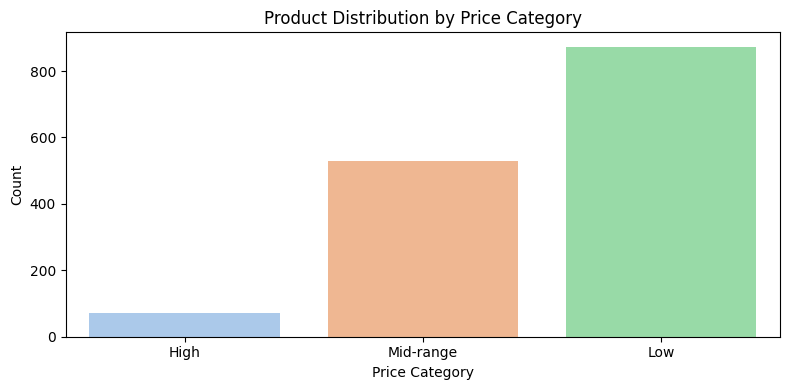

In [36]:
# Visualization 1: Product count by price category
plt.figure(figsize=(8, 4))
sns.countplot(x='Price_category', data=cosmetics_df, palette='pastel')
plt.title("Product Distribution by Price Category")
plt.xlabel("Price Category")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

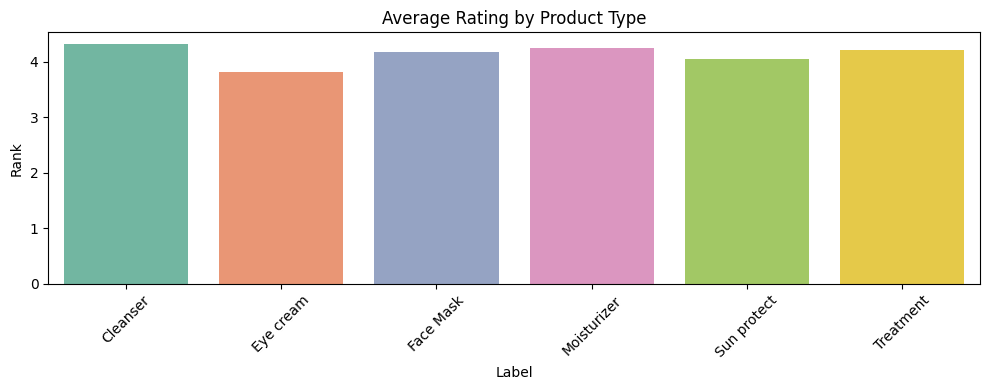

In [37]:
# Visualization 2: Average rating by product type
plt.figure(figsize=(10, 4))
avg_ratings = cosmetics_df.groupby('Label')['Rank'].mean().reset_index()
sns.barplot(x='Label', y='Rank', data=avg_ratings, palette='Set2')
plt.title("Average Rating by Product Type")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


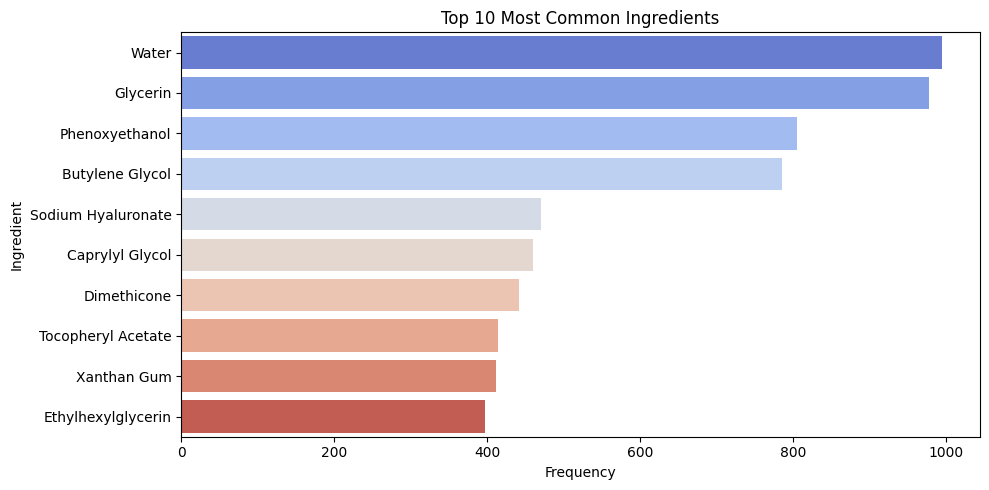

In [38]:
# Visualization 3: Top 10 most frequent ingredients
ingredient_list = cosmetics_df['Ingredients'].dropna().apply(lambda x: [i.strip() for i in x.split(',')])
flat_ingredients = list(chain.from_iterable(ingredient_list))
common_ingredients = Counter(flat_ingredients).most_common(10)
labels, values = zip(*common_ingredients)
plt.figure(figsize=(10, 5))
sns.barplot(x=list(values), y=list(labels), palette='coolwarm')
plt.title("Top 10 Most Common Ingredients")
plt.xlabel("Frequency")
plt.ylabel("Ingredient")
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


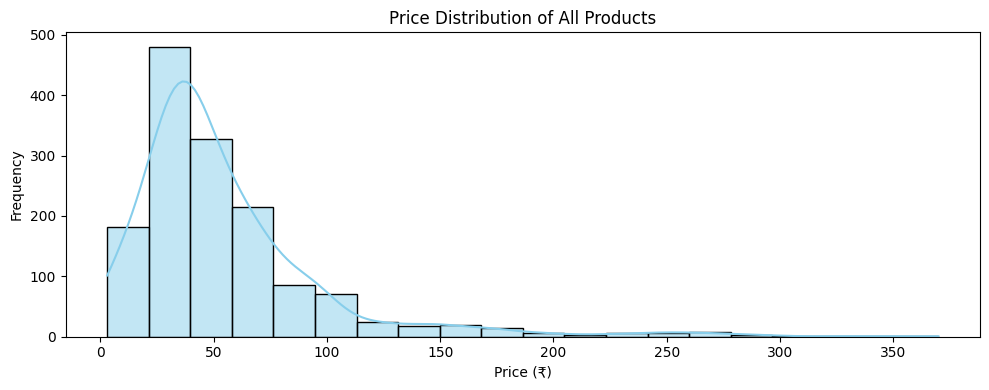

In [39]:
# Visualization 4: Distribution of product prices
plt.figure(figsize=(10, 4))
sns.histplot(cosmetics_df['Price'], bins=20, kde=True, color='skyblue')
plt.title("Price Distribution of All Products")
plt.xlabel("Price (₹)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


In [40]:
# Skin type labels available in dataset
SKIN_TYPES = ['Dry', 'Normal', 'Oily']
SKIN_TONES = ['Black', 'Brown', 'White']
ACNE_SEVERITIES = ['Mild', 'Moderate', 'Severe']
PRODUCT_TYPES = cosmetics_df['Label'].unique().tolist()
print("Available product types:", PRODUCT_TYPES)

Available product types: ['Moisturizer', 'Cleanser', 'Treatment', 'Face Mask', 'Eye cream', 'Sun protect']


In [41]:
def preprocess_image(image):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    return transform(image).unsqueeze(0)

# Load PyTorch model from .pt file (supports full model)
def load_model(model_path):
    model = torch.load(model_path, map_location=torch.device('cpu'), weights_only=False)  # For full model loading
    if hasattr(model, 'module'):
        model = model.module
    model.eval()
    return model

# Predict function
def predict(model, image_tensor, class_labels):
    with torch.no_grad():
        outputs = model(image_tensor)
        predicted_idx = outputs.argmax(dim=1).item()
        return class_labels[predicted_idx]

In [42]:
# Content-based filtering
def content_based_filter(df, skin_type, skin_tone, acne_severity):
    if skin_type in df.columns:
        df = df[df[skin_type] == 1]

    # Skin tone considerations
    if skin_tone == 'Black':
        avoid = ['Titanium Dioxide', 'Zinc Oxide', 'White Cast']
        df = df[~df['Ingredients'].str.contains('|'.join(avoid), case=False, na=False)]
    elif skin_tone == 'White':
        preferred = ['SPF', 'Sunscreen', 'Titanium Dioxide']
        df = df[df['Ingredients'].str.contains('|'.join(preferred), case=False, na=False)]
    elif skin_tone == 'Brown':
        avoid = ['Alcohol Denat', 'Fragrance']
        df = df[~df['Ingredients'].str.contains('|'.join(avoid), case=False, na=False)]

    # Acne severity considerations
    if acne_severity == 'Severe':
        avoid = ['Coconut Oil', 'Isopropyl', 'Lanolin', 'Myristate', 'Fragrance', 'Petrolatum']
        df = df[~df['Ingredients'].str.contains('|'.join(avoid), case=False, na=False)]
    elif acne_severity == 'Moderate':
        avoid = ['Coconut Oil', 'Lanolin']
        df = df[~df['Ingredients'].str.contains('|'.join(avoid), case=False, na=False)]
    elif acne_severity == 'Mild':
        preferred = ['Niacinamide', 'Salicylic Acid', 'Zinc', 'Glycerin', 'Butylene Glycol', 'Phenoxyethanol', 'Sodium Hyaluronate']
        df = df[df['Ingredients'].str.contains('|'.join(preferred), case=False, na=False)]

    return df

In [43]:
# Collaborative filtering using KNN on TF-IDF features
def collaborative_filtering(df, top_n=5):
    tfidf = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tfidf.fit_transform(df['Ingredients'].fillna(""))
    knn = NearestNeighbors(n_neighbors=min(top_n, len(df)), metric='cosine')
    knn.fit(tfidf_matrix)
    distances, indices = knn.kneighbors(tfidf_matrix)
    similar_indices = indices[0]
    return df.iloc[similar_indices]

# Combined recommendation
def get_recommendations(skin_type, skin_tone, acne_severity, product_type, price_category=None, top_n=5):
    df = cosmetics_df[cosmetics_df['Label'].str.lower() == product_type.lower()].copy()
    if price_category:
        df = df[df['Price_category'].str.lower() == price_category.lower()]
    filtered = content_based_filter(df, skin_type, skin_tone, acne_severity)
    final = collaborative_filtering(filtered, top_n=top_n)
    return final[['Label', 'Brand', 'Name', 'Price', 'Rank']]


In [44]:
# Load image
img = Image.open("/kaggle/input/images/oily.jpg").convert('RGB')  # Change to your input image

In [45]:
# Preprocess
tensor = preprocess_image(img)

In [46]:
# Load models
skin_type_model = load_model("/kaggle/input/models/oily_dry_normal.pt")
tone_model = load_model("/kaggle/input/models/skin_tone.pt")
acne_model = load_model("/kaggle/input/models/acne.pt")

In [47]:
# Predict
skin_type = predict(skin_type_model, tensor, SKIN_TYPES)
skin_tone = predict(tone_model, tensor, SKIN_TONES)
acne_severity = predict(acne_model, tensor, ACNE_SEVERITIES)

print(f"Predicted Skin Type: {skin_type}, Tone: {skin_tone}, Acne: {acne_severity}")

Predicted Skin Type: Oily, Tone: White, Acne: Moderate


In [49]:
# Get recommendations
# Let user specify product type and category-based budget range
product_type = "Eye cream"  # Options: Moisturizer, Cleanser, etc.
price_category = "Low"   # Options: Budget, Mid-range, Premium

recommendations = get_recommendations(skin_type, skin_tone, acne_severity, product_type=product_type, price_category=price_category)
print("Top Recommendations:")
print(recommendations.reset_index(drop=True))

Top Recommendations:
       Label         Brand  \
0  Eye cream  OLEHENRIKSEN   
1  Eye cream       ORIGINS   
2  Eye cream         TARTE   
3  Eye cream      CLINIQUE   
4  Eye cream      SHISEIDO   

                                                   Name  Price  Rank  
0                               Banana Bright Eye Crème     38   4.2  
1  GinZing™ Refreshing Eye Cream to Brighten and Depuff     32   4.0  
2                    Maracuja C-Brighter™ Eye Treatment     38   4.0  
3                                  All About Eyes™ Rich     32   4.2  
4                          Essential Energy Eye Definer     42   0.0  
